In [21]:
%matplotlib inline

from utils.data_access_api import DataAccessApi
from utils.dc_utilities import write_geotiff_from_xr, create_cfmask_clean_mask
from utils.dc_chunker import create_geographic_chunks, combine_geographic_chunks
from utils.dc_mosaic import create_median_mosaic
from utils.dc_clustering import kmeans_cluster_dataset

from datetime import datetime
import xarray as xr
import gdal
import numpy as np

dc = DataAccessApi()

lat_range = (10.9, 11.00)
lon_range = (107.8, 107.9)
time_range = (datetime(2015,1,1), datetime(2017,1,1))

In [14]:
product = "ls8_ledaps_vietnam"
platform = "LANDSAT_8"

In [15]:
dc.get_datacube_metadata(platform=platform,product=product)

{'lat_extents': (10.505707416254989, 12.61854496450523),
 'lon_extents': (106.77698860552604, 108.9289028686355),
 'pixel_count': 62602400,
 'scene_count': 38,
 'time_extents': (datetime.datetime(2015, 1, 1, 3, 7, 41),
  datetime.datetime(2016, 12, 21, 3, 7, 54))}

In [16]:
product_details = dc.dc.list_products()[dc.dc.list_products().name == product]

acquisitions = dc.list_acquisition_dates("LANDSAT_8", product, time=time_range, 
                                         longitude=lon_range, latitude=lat_range)

geographic_chunks = create_geographic_chunks(latitude=lat_range, longitude=lon_range, geographic_chunk_size=.05)


In [17]:
measurements = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'cf_mask']
product_chunks = []

for index, chunk in enumerate(geographic_chunks):
    data = dc.get_dataset_by_extent(product, time=time_range, 
                                    longitude=chunk['longitude'], latitude=chunk['latitude'], 
                                    measurements=measurements)
    clean_mask = create_cfmask_clean_mask(data.cf_mask)
    product_chunks.append(create_median_mosaic(data, clean_mask=clean_mask))
    
final_mosaic = combine_geographic_chunks(product_chunks)

write_geotiff_from_xr("ls8_median_mosaic.tif", final_mosaic, measurements, nodata=-9999)

In [18]:
final_mosaic

<xarray.Dataset>
Dimensions:    (latitude: 372, longitude: 372)
Coordinates:
  * longitude  (longitude) float64 107.8 107.8 107.8 107.8 107.8 107.8 107.8 ...
  * latitude   (latitude) float64 11.0 11.0 11.0 11.0 11.0 11.0 11.0 11.0 ...
Data variables:
    blue       (latitude, longitude) int32 130 132 131 134 142 148 151 153 ...
    green      (latitude, longitude) int32 364 360 345 334 391 429 440 417 ...
    red        (latitude, longitude) int32 199 205 186 202 251 270 301 280 ...
    nir        (latitude, longitude) int32 3397 3184 2980 2814 3174 3573 ...
    swir1      (latitude, longitude) int32 1524 1507 1469 1320 1504 1734 ...
    swir2      (latitude, longitude) int32 576 592 553 514 602 672 710 683 ...
    cf_mask    (latitude, longitude) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...

In [20]:
classification_4 = kmeans_cluster_dataset(final_mosaic, n_clusters=4)
classification_8 = kmeans_cluster_dataset(final_mosaic, n_clusters=8)
classification_12 = kmeans_cluster_dataset(final_mosaic, n_clusters=12)

write_geotiff_from_xr("ls8_cluster4.tif", classification_4, ['classification'], nodata=-9999)
write_geotiff_from_xr("ls8_cluster8.tif", classification_8, ['classification'], nodata=-9999)
write_geotiff_from_xr("ls8_cluster12.tif", classification_12, ['classification'], nodata=-9999)

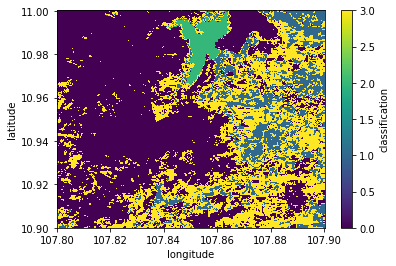

In [23]:
classification_4.classification.plot()

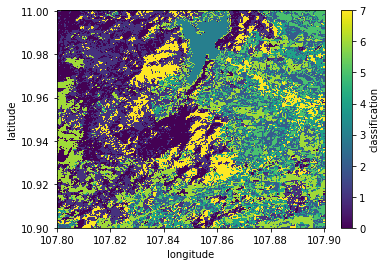

In [24]:
classification_8.classification.plot()

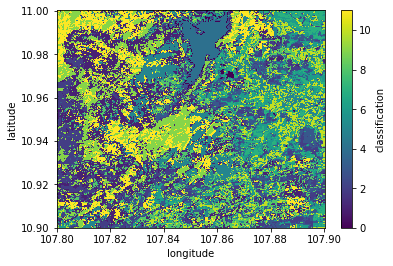

In [25]:
classification_12.classification.plot()